# Analysis of Surface Fields

`mom6_tools.MOM6grid` returns an object with MOM6 grid data.

`mom6_tools.latlon_analysis` has a collection of tools used to perform spatial analysis  (e.g., time averages and spatial mean).

The goal of this notebook is the following:

1) server as an example of how to post-process CESM/MOM6 output;

2) create time averages of surface fields.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, yaml, argparse
import pandas as pd
import dask, intake
from datetime import datetime, date
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.m6toolbox import cime_xmlquery
from mom6_tools.m6toolbox import add_global_attrs
from mom6_tools.m6plot import xycompare, xyplot
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.surface import get_SSH, get_MLD, get_BLD

Basemap module not found. Some regional plots may not function properly


ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/gmarques/conda-envs/mom6-tools/share/proj failed


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [4]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')

In [5]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass

# load avg dates
avg = diag_config_yml['Avg']

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = casename
args.native = casename+diag_config_yml['Fnames']['native']
args.static = casename+diag_config_yml['Fnames']['static']
args.geom =   casename+diag_config_yml['Fnames']['geom']
args.label =  diag_config_yml['Case']['SNAME']
args.mld_obs = "mld-deboyer-tx2_3v2"
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [6]:
if not os.path.isdir('PNG/BLD'):
  print('Creating a directory to place figures (PNG/BLD)... \n')
  os.system('mkdir -p PNG/BLD')
if not os.path.isdir('PNG/MLD'):
  print('Creating a directory to place figures (PNG/MLD)... \n')
  os.system('mkdir -p PNG/MLD')
if not os.path.isdir('ncfiles'):
  print('Creating a directory to place netcdf files (ncfiles)... \n')
  os.system('mkdir ncfiles')    

In [7]:
parallel = False
if args.nw > 1:
  parallel = True
  cluster = NCARCluster()
  cluster.scale(args.nw)
  client = Client(cluster)
  client

In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:38481,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static)
  
try:
  depth = grd.depth_ocean
except:
  depth = grd.deptho

MOM6 grid successfully loaded... 



In [10]:
print('Reading native dataset...')
startTime = datetime.now()

def preprocess(ds):
    ''' Compute montly averages and return the dataset with variables'''
    variables = ['oml','mlotst','tos','SSH', 'SSU', 'SSV', 'speed']
    if 'time_bounds' in ds.variables:
      variables.append('time_bounds')
    elif 'time_bnds' in ds.variables:
      variables.append('time_bnds')
    for v in variables:
      if v not in ds.variables:
        ds[v] = xr.zeros_like(ds.SSH)
    return ds[variables]

ds1 = xr.open_mfdataset(OUTDIR+args.native, parallel=parallel)
ds = preprocess(ds1)

print('Time elasped: ', datetime.now() - startTime)

Reading native dataset...
Time elasped:  0:00:41.190045


In [11]:
print('Selecting data between {} and {}...'.format(args.start_date, args.end_date))
ds_sel = ds.sel(time=slice(args.start_date, args.end_date))

Selecting data between 0031-01-01 and 0062-01-01...


In [12]:
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
mld_obs = catalog[args.mld_obs].to_dask()
# uncomment to list all datasets available
#list(catalog)

In [13]:
mld_clima = ds_sel['mlotst'].groupby("time.month").mean('time').compute()

In [14]:
mld_clima = mld_clima.assign_coords({
    "latitude": (("yh", "xh"), grd.geolat),
    "longitude": (("yh", "xh"), grd.geolon)
})

In [15]:
# Create the faceted plot
fig = plt.figure(figsize=(15, 10))  # Adjust figure size
plot = mld_clima.plot(
    x="longitude", 
    y="latitude", 
    col="month", 
    col_wrap=4,  # Arrange plots in a grid with 4 columns
    cmap="viridis",  # Choose a color map
    robust=True,  # Automatically set vmin/vmax for better scaling
    cbar_kwargs={
        "orientation": "horizontal",  # Horizontal colorbar
        "pad": 0.05,  # Space between colorbar and plots
        "aspect": 40,  # Control the width of the colorbar
        "shrink": 0.8,  # Shrink the colorbar size
        "label": "MLD monthly climatology (m)"  # Customize colorbar label
    }
)
plt.suptitle('{}, from {} to {}'.format(args.label, args.start_date, 
            args.end_date), fontsize=16, fontweight='bold')
# Fine-tune layout
plt.subplots_adjust(top=0.93, bottom=0.26)  # Move the plots up to create space below
plt.show()

In [16]:
# Add a 'month' coordinate to 'reference'
mld_obs_with_month = mld_obs.assign_coords(month=mld_clima.month)

In [18]:
mld_obs_monthly = mld_obs_with_month.groupby("month").mean(dim="time")
mld_obs_monthly

<xarray.Dataset> Size: 17MB
Dimensions:  (month: 12, yh: 480, xh: 540)
Coordinates:
    lon      (yh, xh) float64 2MB dask.array<chunksize=(480, 540), meta=np.ndarray>
    lat      (yh, xh) float64 2MB dask.array<chunksize=(480, 540), meta=np.ndarray>
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: yh, xh
Data variables:
    mld      (month, yh, xh) float32 12MB dask.array<chunksize=(12, 480, 540), meta=np.ndarray>

In [19]:
bias = mld_clima - mld_obs_monthly.mld

<Figure size 1500x1000 with 0 Axes>

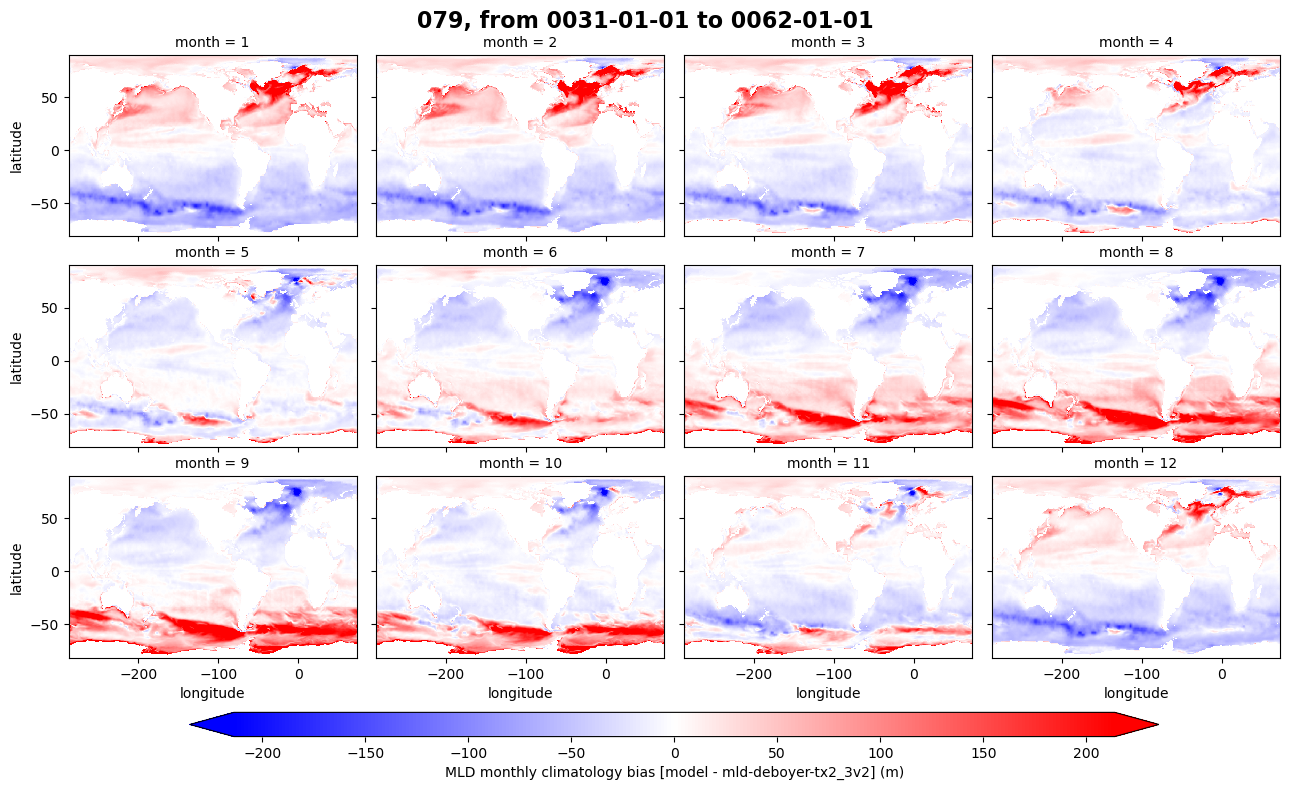

In [23]:
%matplotlib inline

# Create the faceted plot
fig = plt.figure(figsize=(15, 10))  # Adjust figure size
plot = bias.plot(
    x="longitude", 
    y="latitude", 
    col="month", 
    col_wrap=4,  
    cmap="bwr", 
    robust=True,  
    cbar_kwargs={
        "orientation": "horizontal",  # Horizontal colorbar
        "pad": 0.05,  # Space between colorbar and plots
        "aspect": 40,  # Control the width of the colorbar
        "shrink": 0.8,  # Shrink the colorbar size
        "label": "MLD monthly climatology bias [model - {}] (m)".format(args.mld_obs)  # Customize colorbar label
    }
)
plt.suptitle('{}, from {} to {}'.format(args.label, args.start_date, 
            args.end_date), fontsize=16, fontweight='bold')
# Fine-tune layout
plt.subplots_adjust(top=0.93, bottom=0.26)  # Move the plots up to create space below
plt.show()

### Mixed layer depth

In [13]:
%matplotlib inline
# MLD
get_MLD(ds_sel,'mlotst', mld_obs, grd, args)

Computing monthly MLD climatology...
Time elasped:  0:00:09.007238

 Plotting...


### Boundary layer depth

Computing monthly BLD climatology...
Time elasped:  0:00:09.901577

 Plotting...


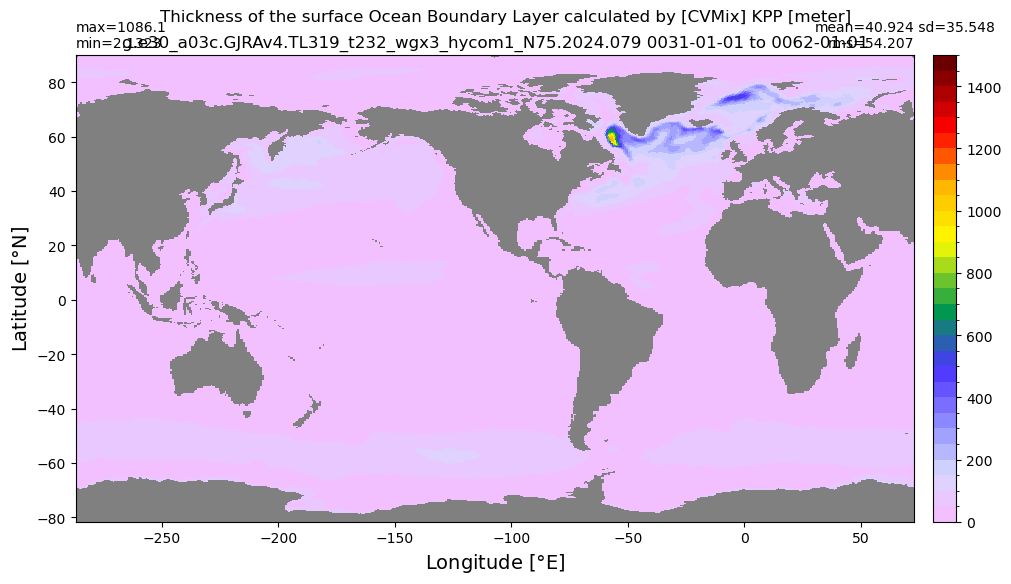

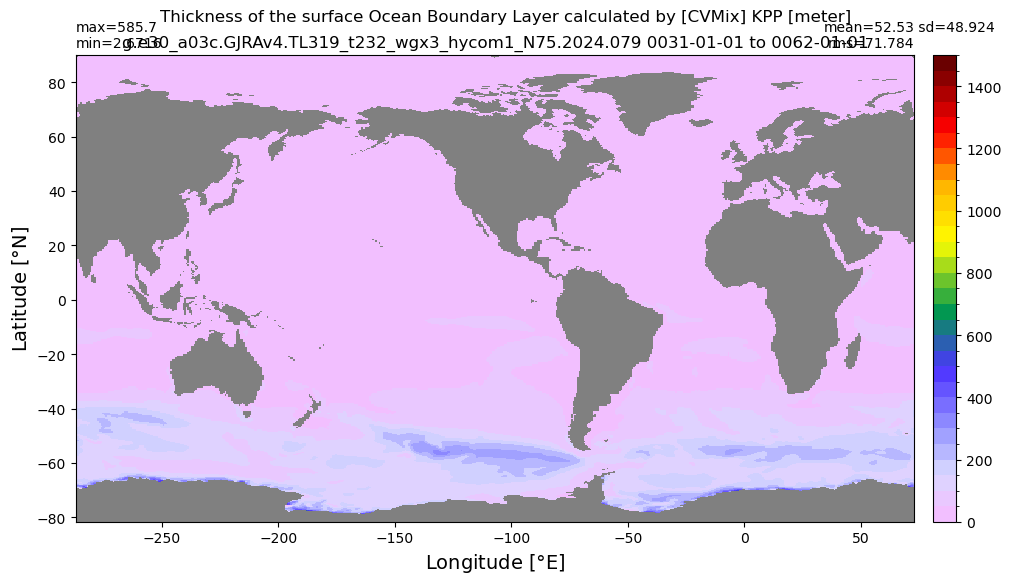

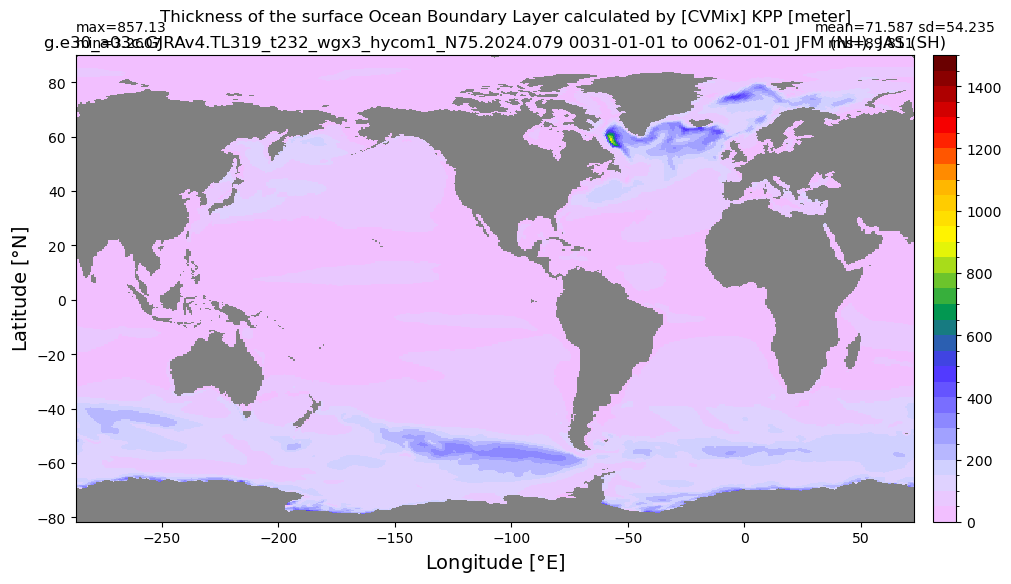

In [14]:
get_BLD(ds_sel, 'oml', grd, args)

In [15]:
# SSH (not working)
#get_SSH(ds, 'SSH', grd, args)

In [16]:
if parallel:
    print('\n Releasing workers...')
    client.close(); cluster.close()


 Releasing workers...
